In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def get_data(ticker="AAPL", start="2024-01-01", end="2024-01-10", interval="1m"):
    df = yf.download(ticker, start=start, end=end, interval=interval)
    df = df.reset_index()
    df['Mid'] = (df['High'] + df['Low']) / 2
    return df[['Datetime', 'Mid']]

In [3]:
class MarketEnvReal:
    def __init__(self, price_series, lambda_hit=0.3):
        self.price_series = price_series
        self.lambda_hit = lambda_hit
        self.idx = 0

    def step_price(self):
        """Get next real mid-price from historical data."""
        price = self.price_series[self.idx]
        self.idx += 1
        return price

    def sample_hits(self, bid_dist, ask_dist):
        """Execution probability based on distance from mid."""
        p_bid = self.lambda_hit * np.exp(-bid_dist)
        p_ask = self.lambda_hit * np.exp(-ask_dist)
        return (np.random.rand() < p_bid), (np.random.rand() < p_ask)

In [4]:
class NaiveMM:
    def __init__(self, spread=0.2, size=1):
        self.spread = spread
        self.size = size
        self.inventory = 0
        self.cash = 0

    def quotes(self, mid_price):
        bid = mid_price - self.spread / 2
        ask = mid_price + self.spread / 2
        return bid, ask

class InventoryAwareMM:
    def __init__(self, spread=0.2, size=1, risk_aversion=0.05):
        self.spread = spread
        self.size = size
        self.risk_aversion = risk_aversion
        self.inventory = 0
        self.cash = 0

    def quotes(self, mid_price):
        skew = self.risk_aversion * self.inventory
        bid = mid_price - self.spread / 2 - skew
        ask = mid_price + self.spread / 2 - skew
        return bid, ask

In [5]:
def simulate(env, mm, T):
    records = []
    for t in range(T):
        mid = env.step_price()
        bid, ask = mm.quotes(mid)

        bid_hit, ask_hit = env.sample_hits(mid - bid, ask - mid)

        if bid_hit:
            mm.inventory += mm.size
            mm.cash -= bid * mm.size
        if ask_hit:
            mm.inventory -= mm.size
            mm.cash += ask * mm.size

        mtm = mm.cash + mm.inventory * mid
        records.append({
            't': t, 'mid': mid, 'bid': bid, 'ask': ask,
            'inv': mm.inventory, 'cash': mm.cash, 'mtm': mtm
        })

    return pd.DataFrame(records)


In [12]:
TICKER = "AAPL"      # Editable ticker
START_DATE = "2025-07-15"
END_DATE = "2025-07-25"
INTERVAL = "5m"      # '1m', '5m', '15m', '1h', '1d'

In [13]:
df_prices = get_data(TICKER, START_DATE, END_DATE, INTERVAL)
price_series = df_prices['Mid'].values
T = len(price_series)

# Naive
env1 = MarketEnvReal(price_series)
mm1 = NaiveMM(spread=0.2)
df_naive = simulate(env1, mm1, T)

# Inventory-aware
env2 = MarketEnvReal(price_series)
mm2 = InventoryAwareMM(spread=0.2, risk_aversion=0.05)
df_inv = simulate(env2, mm2, T)

[*********************100%***********************]  1 of 1 completed


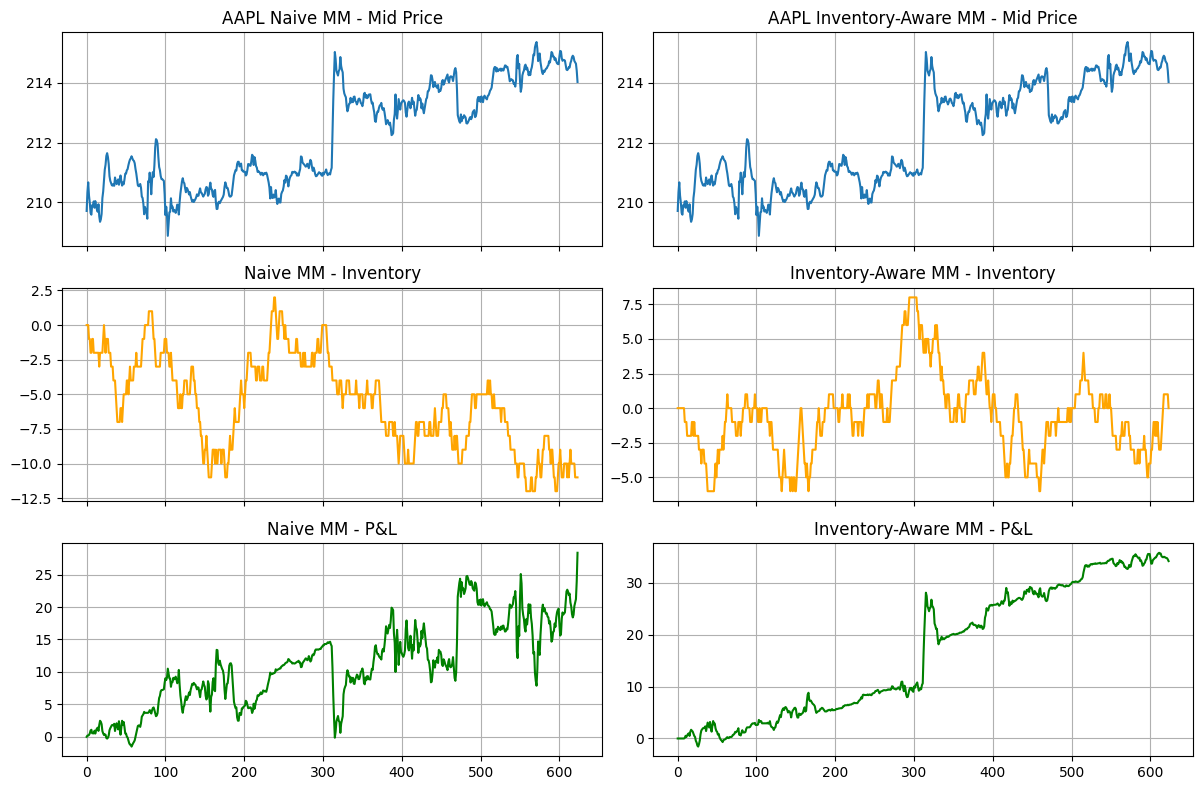

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

# Mid-price
axes[0,0].plot(df_naive['t'], df_naive['mid'])
axes[0,0].set_title(f'{TICKER} Naive MM - Mid Price')
axes[0,1].plot(df_inv['t'], df_inv['mid'])
axes[0,1].set_title(f'{TICKER} Inventory-Aware MM - Mid Price')

# Inventory
axes[1,0].plot(df_naive['t'], df_naive['inv'], color='orange')
axes[1,0].set_title('Naive MM - Inventory')
axes[1,1].plot(df_inv['t'], df_inv['inv'], color='orange')
axes[1,1].set_title('Inventory-Aware MM - Inventory')

# P&L
axes[2,0].plot(df_naive['t'], df_naive['mtm'], color='green')
axes[2,0].set_title('Naive MM - P&L')
axes[2,1].plot(df_inv['t'], df_inv['mtm'], color='green')
axes[2,1].set_title('Inventory-Aware MM - P&L')

for ax in axes.flat:
    ax.grid(True)

plt.tight_layout()
plt.show()